<a href="https://colab.research.google.com/github/kvdprasad89ai/machine-learning/blob/master/Text_Classification_from_PDF_files.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
import cv2
import numpy as np
import pandas as pd
import requests
import io
import json
import os
from google.colab import drive

In [107]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
!pip install PyPDF2
import PyPDF2
import glob
import re
from PyPDF2 import PdfFileReader

In [109]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [110]:

pdf_dir = "/content/drive/My Drive//text classification/pdf_data"

text_dic = {}
pdf_files = glob.glob("%s/*.pdf" % pdf_dir)
for file in pdf_files:
    print(file)
    if file.endswith('.pdf'):
        fileReader = PyPDF2.PdfFileReader(open(file, "rb"))
        file_name = file[len(pdf_dir)+1:] 
        count = 0
        count = fileReader.numPages
        text = ""
        while count >= 0:
            count -= 1
            pageObj = fileReader.getPage(count)
            text += pageObj.extractText()
            #print(text)
        text_dic[file_name] = text



/content/drive/My Drive//text classification/pdf_data/Andre Agassi.pdf
/content/drive/My Drive//text classification/pdf_data/Ayrton Senna.pdf
/content/drive/My Drive//text classification/pdf_data/Cristiano Ronaldo.pdf
/content/drive/My Drive//text classification/pdf_data/G.H. Hardy.pdf
/content/drive/My Drive//text classification/pdf_data/Lenny Bruce.pdf
/content/drive/My Drive//text classification/pdf_data/Lionel Messi.pdf
/content/drive/My Drive//text classification/pdf_data/Michael Schumacher.pdf
/content/drive/My Drive//text classification/pdf_data/Pete Sampras.pdf
/content/drive/My Drive//text classification/pdf_data/Roger Federer.pdf
/content/drive/My Drive//text classification/pdf_data/Srinivasa Ramanujan.pdf


In [111]:
print(len(text_dic))

10


In [112]:
text_dataframe = pd.DataFrame(list(text_dic.items()),columns = ['file_name','text'])
text_dataframe

,file_name,text
0,Andre Agassi.pdf,1996. In 1997 Agassi made headlines with his m...
1,Ayrton Senna.pdf,coveted pole position a record 65 times for ha...
2,Cristiano Ronaldo.pdf,the semifinals of the\n \nEuropean Championshi...
3,G.H. Hardy.pdf,"attached little importance to the law, it beca..."
4,Lenny Bruce.pdf,Creel in a dissenting opinion noted that decis...
5,Lionel Messi.pdf,Spain are given suspended sentences if the dur...
6,Michael Schumacher.pdf,While Schumacher experienced unprecedented suc...
7,Pete Sampras.pdf,U.S. team that won the 1995\n \nDavis Cup\n. A...
8,Roger Federer.pdf,He\n \nentered the first Grand Slam tournament...
9,Srinivasa Ramanujan.pdf,"the\n \nzeta f\nunction\n, and his own theory ..."


In [113]:
def tweet_preprocessing(text_dataframe):
    #Replacing all special symbols
    text_dataframe['clean_text'] = text_dataframe['text'].replace(to_replace ='(@[\w]+)', value ='', regex = True) 
    
    #remove any links from the tweet: Links not required for performing sentiment analysis.
    text_dataframe['clean_text'] = text_dataframe['clean_text'].str.replace('((www\.[\s]+)|(https?://[^\s]+))','\0',regex=True)
    
    # remove special characters, numbers, punctuations: None of them would add any value to the sentiment score.
    text_dataframe['clean_text'] = text_dataframe['clean_text'].str.replace("[^a-zA-Z]+", " ")
    
    #Converting into lower case and splitting into wrods.
    text_dataframe["clean_text"] = text_dataframe["clean_text"].str.lower()
    text_dataframe["clean_text"] = text_dataframe["clean_text"].str.split()
    #Loading stop words
    from nltk.corpus import stopwords
    stop = stopwords.words('english')
    text_dataframe['clean_text']=text_dataframe['clean_text'].apply(lambda x: [item for item in x if item not in stop])
    
    return text_dataframe
text_dataframe = tweet_preprocessing(text_dataframe)

In [114]:
def rejoin_words(row):
    my_list = row['clean_text']
    joined_words = ( " ".join(my_list))
    return joined_words

text_dataframe['clean_text'] = text_dataframe.apply(rejoin_words, axis=1)
text_dataframe['clean_text'][1]

'coveted pole position record times fastest race qualifying times enigmatic figure deeply religious yet highly aggressi racetrack senna thrilled spectators cowed competitors fearsome driving invited controversy long standing rivalry frenchman alain prost titles successful driver two collided penultimate race season prost emerged victorious season senna captured world crown reportedly earned million career included annual salary million ratzenberger killed similar accident qualifying trials deaths renewed concerns recent rule changes f ration believed made sport dangerous brazilian race car driver senna british french documentary film depicts life death brazilian motor racing champion ayrton senna directed asif kapadia film produced studiocanal working title films midfield films distributed parent company latter two production companies universal pictures film narrative focuses senna racing career formula one debut brazilian grand prix death accident san marino grand prix particular emp

In [115]:
nltk.download('wordnet')

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

text_dataframe['clean_text'] = text_dataframe['clean_text'].apply(lemmatize_text)
text_dataframe['clean_text'] = text_dataframe.apply(rejoin_words, axis=1)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [116]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = tfidf.fit_transform(text_dataframe['clean_text'])
dtm

<10x372 sparse matrix of type '<class 'numpy.float64'>'
	with 1000 stored elements in Compressed Sparse Row format>

In [117]:
from sklearn.decomposition import NMF
nmf_model = NMF(n_components=5,random_state=100)
nmf_model.fit(dtm)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=5, random_state=100, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [118]:
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 25 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-25:]])
    print('\n')

THE TOP 25 WORDS FOR TOPIC #0
['career', 'inducted', 'game', 'djokovic', 'set', 'professional', 'coach', 'year', 'andre', 'single', 'final', 'win', 'grand', 'title', 'ranking', 'slam', 'australian', 'tournament', 'player', 'federer', 'wimbledon', 'sampras', 'agassi', 'tennis', 'open']


THE TOP 25 WORDS FOR TOPIC #1
['london', 'england', 'indian', 'published', 'law', 'work', 'royal', 'elected', 'india', 'function', 'pure', 'cambridge', 'university', 'divergent', 'mathematical', 'genius', 'society', 'paper', 'number', 'series', 'theory', 'mathematics', 'mathematician', 'hardy', 'ramanujan']


THE TOP 25 WORDS FOR TOPIC #2
['stage', 'club', 'million', 'spain', 'played', 'champion', 'fifa', 'helped', 'title', 'match', 'cup', 'year', 'football', 'season', 'la', 'team', 'player', 'liga', 'world', 'league', 'barcelona', 'scored', 'messi', 'ronaldo', 'goal']


THE TOP 25 WORDS FOR TOPIC #3
['sport', 'career', 'year', 'death', 'championship', 'time', 'annual', 'head', 'team', 'track', 'title',

In [119]:
topic_results = nmf_model.transform(dtm)
#topic_results.argmax(axis=1)

text_dataframe['Topic'] = topic_results.argmax(axis=1)

text_dataframe


,file_name,text,clean_text,Topic
0,Andre Agassi.pdf,1996. In 1997 Agassi made headlines with his m...,agassi made headline marriage actress brooke s...,0
1,Ayrton Senna.pdf,coveted pole position a record 65 times for ha...,coveted pole position record time fastest race...,3
2,Cristiano Ronaldo.pdf,the semifinals of the\n \nEuropean Championshi...,semifinal european championship team eliminate...,2
3,G.H. Hardy.pdf,"attached little importance to the law, it beca...",attached little importance law became central ...,1
4,Lenny Bruce.pdf,Creel in a dissenting opinion noted that decis...,creel dissenting opinion noted decision u obsc...,4
5,Lionel Messi.pdf,Spain are given suspended sentences if the dur...,spain given suspended sentence duration two de...,2
6,Michael Schumacher.pdf,While Schumacher experienced unprecedented suc...,schumacher experienced unprecedented success t...,3
7,Pete Sampras.pdf,U.S. team that won the 1995\n \nDavis Cup\n. A...,u team davis cup surprising win u open sampras...,0
8,Roger Federer.pdf,He\n \nentered the first Grand Slam tournament...,entered first grand slam tournament australian...,0
9,Srinivasa Ramanujan.pdf,"the\n \nzeta f\nunction\n, and his own theory ...",zeta f unction theory divergent series hand kn...,1


In [120]:
text_dataframe['clean_text'][6]

'schumacher experienced unprecedented success track also endorsement one best paid athlete history sport annual income estimated million peak career schumacher also known charitable effort named special ambassador unesco made headline million donation relief effort indian ocean tsunami december schumacher fell skiing france hit head rock despite wearing helmet time accident sustained significant brain injury placed medically induced coma following june german race car driver michael schumacher byname schumi born january h rth herm lhein west germany germany german race car driver set record formula one f grand prix race victory f series championship youth schumacher became interested go kart racing kart track german junior karting championship ca ptured german european karting title next year age left karting became driver formula three f car vehicle le powerful f racer two year later german f championship schumacher moved f competition driver jordan team switched benetton following ye

In [121]:
text_dataframe.iloc[6]['clean_text']

'schumacher experienced unprecedented success track also endorsement one best paid athlete history sport annual income estimated million peak career schumacher also known charitable effort named special ambassador unesco made headline million donation relief effort indian ocean tsunami december schumacher fell skiing france hit head rock despite wearing helmet time accident sustained significant brain injury placed medically induced coma following june german race car driver michael schumacher byname schumi born january h rth herm lhein west germany germany german race car driver set record formula one f grand prix race victory f series championship youth schumacher became interested go kart racing kart track german junior karting championship ca ptured german european karting title next year age left karting became driver formula three f car vehicle le powerful f racer two year later german f championship schumacher moved f competition driver jordan team switched benetton following ye

In [122]:
from collections import Counter
text_dataframe['temp_list'] = text_dataframe['clean_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in text_dataframe['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,year,50
1,open,45
2,world,43
3,title,41
4,player,36
5,season,35
6,goal,34
7,one,31
8,team,31
9,tennis,30


In [123]:
!pip install plotly==4.8.2
import plotly.express as px
import plotly.figure_factory as ff
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [124]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

In [125]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()




# > word cloud reprasenation for entire data set
# bold text







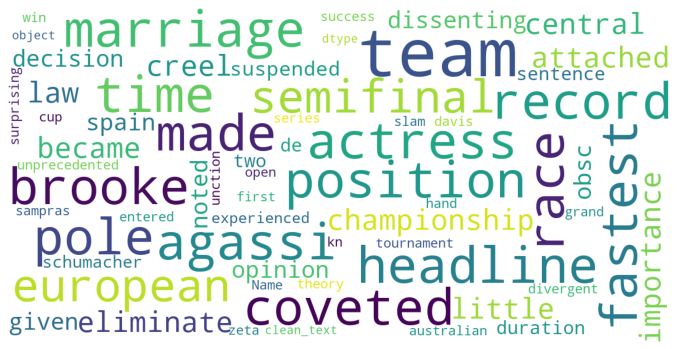

In [126]:
show_wordcloud(text_dataframe['clean_text'])

# Word cloud most frequest words for **Schumacher**

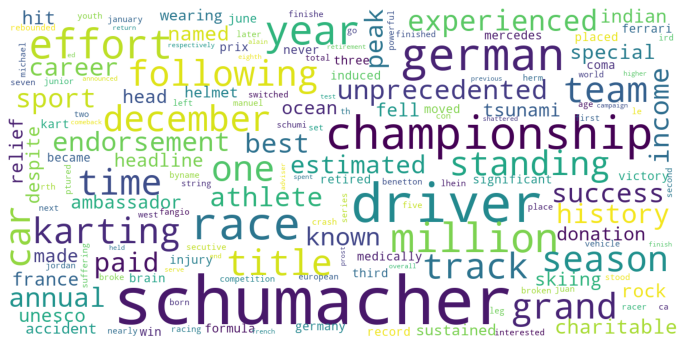

In [127]:
show_wordcloud(text_dataframe.iloc[6]['clean_text'])

# Word cloud most frequest words for **Senna**

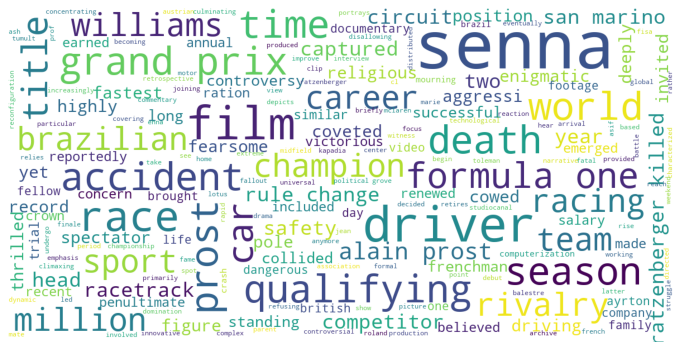

In [128]:
show_wordcloud(text_dataframe.iloc[1]['clean_text'])

In [129]:
text_dataframe.drop('temp_list', axis=1, inplace=True)

In [130]:
cleanup_nums = {"Topic": {0: "Tennis", 1:"Mathematician", 2: "FootBall", 3:"Formula One", 4:"Standup Comedy"}}

text_dataframe.replace(cleanup_nums, inplace=True)
text_dataframe

,file_name,text,clean_text,Topic
0,Andre Agassi.pdf,1996. In 1997 Agassi made headlines with his m...,agassi made headline marriage actress brooke s...,Tennis
1,Ayrton Senna.pdf,coveted pole position a record 65 times for ha...,coveted pole position record time fastest race...,Formula One
2,Cristiano Ronaldo.pdf,the semifinals of the\n \nEuropean Championshi...,semifinal european championship team eliminate...,FootBall
3,G.H. Hardy.pdf,"attached little importance to the law, it beca...",attached little importance law became central ...,Mathematician
4,Lenny Bruce.pdf,Creel in a dissenting opinion noted that decis...,creel dissenting opinion noted decision u obsc...,Standup Comedy
5,Lionel Messi.pdf,Spain are given suspended sentences if the dur...,spain given suspended sentence duration two de...,FootBall
6,Michael Schumacher.pdf,While Schumacher experienced unprecedented suc...,schumacher experienced unprecedented success t...,Formula One
7,Pete Sampras.pdf,U.S. team that won the 1995\n \nDavis Cup\n. A...,u team davis cup surprising win u open sampras...,Tennis
8,Roger Federer.pdf,He\n \nentered the first Grand Slam tournament...,entered first grand slam tournament australian...,Tennis
9,Srinivasa Ramanujan.pdf,"the\n \nzeta f\nunction\n, and his own theory ...",zeta f unction theory divergent series hand kn...,Mathematician
